# DS 2500 HW 5

Due: Fri Mar 17 @ 11:59PM

### Submission Instructions
Please submit both of the following to the corresponding [gradescope](https://www.gradescope.com/courses/478298) assignment:
- this `.ipynb` file 
    - give a fresh `Kernel > Restart & Run All` just before uploading
- a `.py` file consistent with your `.ipynb`
    - `File > Download as ...`
    
Gradescope may run your `.py` submission to determine part of your score for this assignment.  See the [autograder instructions](https://github.com/matthigger/gradescope_auto_py/blob/main/stud_instruct.md) for details.


### Tips for success
- Start early
- Make use of [Piazza](https://course.ccs.neu.edu/ds2500/admin_piazza.html)
- Make use of [Office Hours](https://course.ccs.neu.edu/ds2500/office_hours.html)
- Remember that [Documentation / style counts for credit](https://course.ccs.neu.edu/ds2500/python_style.html)
- [No student may view or share their ungraded homework with another](https://course.ccs.neu.edu/ds2500/syllabus.html#academic-integrity-and-conduct)

# Overview: What contributes to property prices in the Boston area?

We're going to analyze a dataset that contains nearly 1000 different condos and houses available for sale circa 2021 in the Boston area. Based on the features of a place and it's location we will try to predict its price.

In [1]:
import pandas as pd

df_boston = pd.read_csv('boston_houses.csv', index_col=None)

df_boston.head()

,beds,baths,area,distance,price,price_bucket
0,3.0,2.0,2584.0,18.726140,1100000.0,price >= 900k
1,1.0,1.0,650.0,1.053808,699000.0,600k <= price < 900k
2,2.0,3.0,1794.0,0.471038,1750000.0,price >= 900k
3,4.0,3.0,1831.0,3.611435,979000.0,price >= 900k
4,3.0,3.0,1875.0,2.200608,1875000.0,price >= 900k


# Part 1: Decision Tree Classifier (21 points)
Our desired target variable is continuous (`price`), though our classifiers require a categorical target (e.g. `species`).  To remedy this, we have first "binned" `price` into three buckets:

In [2]:
df_boston['price_bucket'].value_counts()

price < 600k            321
price >= 900k           320
600k <= price < 900k    313
Name: price_bucket, dtype: int64

1. Build a Decision Tree with `max_depth=2` which estimates the `price_bucket` of housing using 
    - beds
    - baths
    - area
    - distance
1. Plot the tree using [plot_tree()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).  To ensure the visualization is easily understood:
    - increase the size of the figure so text is easily read
    - utlize the `class_names` keyword input to `plot_tree()` which shows the most common class among the `values` shown
1. Validate your tree by identifying one intuitive behavior which it replicates (e.g. larger houses tend to be more expensive)
    - Remember the convention for reading the tree:
        - yes -> left
        - no -> right
        - after training, `dec_tree_clf.classes_` contains the order of classes shown in the `values` lists shown in the tree
    - Please summarize the intuition identified in the tree in a markdown cell just below the tree itself


DecisionTreeClassifier(max_depth=2)

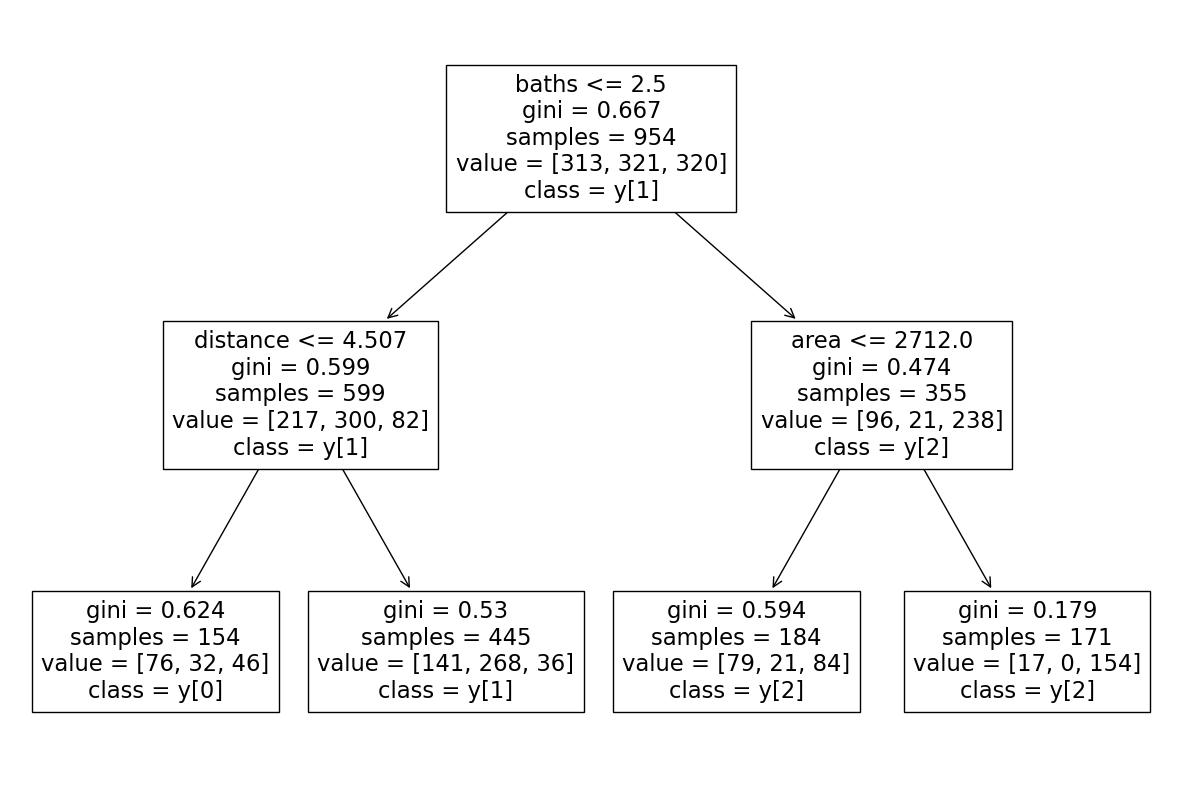

In [3]:
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt

# establish relevant categories
x_feat_list = ['beds', 'baths', 'area', 'distance']

# extract data from dataframe
x = df_boston.loc[:, x_feat_list].values
y = df_boston.loc[:, 'price_bucket'].values
    
# build decision tree classifier
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=2)

# fit data
dec_tree_clf.fit(x, y)
    
# plot decision tree
plt.figure()
plt.gcf().set_size_inches(15, 10)
dec_tree = tree.plot_tree(dec_tree_clf, feature_names=x_feat_list, class_names=True)
    
dec_tree_clf

In [4]:
dec_tree_clf.classes_

array(['600k <= price < 900k', 'price < 600k', 'price >= 900k'],
      dtype=object)

The tree demonstrates that houses with more bathrooms and a greater area are the most expensive as shown by the most rightward path in the tree, which is generally intuitive. 

# Part 2: Random Forest Classification (23 points)
We'd like to quantify how significant each feature (i.e. 'beds', 'baths', 'area', 'distance') is in predicting the `price_bucket` of a property via a Random Forest Analysis.  Of course:

# Nobody cares which features are important to a classifier which doesn't work!

so, before we look at feature importance we must check that our classifier is able to predict `price_bucket` with reasonable accuracy (hint: the solution shows 70% accuracy, which is sufficient for our purposes here).

Using 10 fold cross validation with a Random Forest (max_depth=3) and the same x, y definitions as above:
- construct a confusion matrix which shows performance
- compute accuracy via [accuracy_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

In [5]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import accuracy_score

n_splits = 10
max_depth = 3

# initialize k fold
skfold = StratifiedKFold(n_splits=n_splits)

# create decision tree
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=max_depth)

# create variable to store predictions of y
y_pred = np.empty_like(y)

for train_idx, test_idx in skfold.split(x, y):
    # get training data
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    
    # get test data
    x_test = x[test_idx, :]
    
    # fit data
    dec_tree_clf = dec_tree_clf.fit(x_train, y_train)
    
    # estimate on test data
    y_pred[test_idx] = dec_tree_clf.predict(x_test)

Text(0.5, 0.98, 'max_depth=3 decision tree')

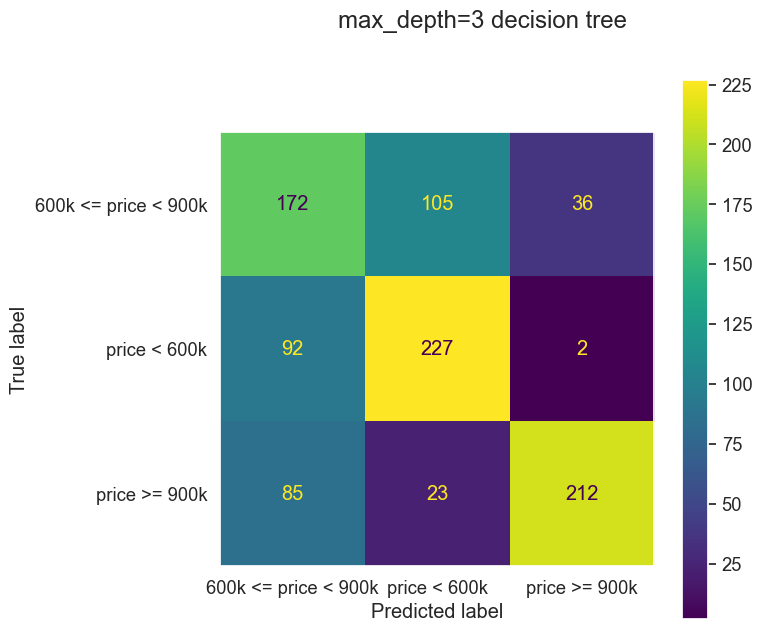

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# create confusion matrix
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)

# display confusion matrix
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y))

# plot formatting
sns.set(font_scale=1.2)
conf_mat_disp.plot()
plt.gcf().set_size_inches(7, 7)
plt.grid(False)
plt.suptitle('max_depth=3 decision tree')

In [7]:
# compute accuracy score
accuracy_score(y, y_pred)

0.640461215932914

# Part 3 Feature Importance in Random Forest (16 points)
1. Fit a Random Forest Classifier on the *entire dataset.  
    - *without k-fold Cross Validation ...
1. Plot the Feature Importances, mean reduction in Gini scores, via `plot_feat_import()`
    - copy this function from class notes as is (no need to cite here)
1. In a markdown cell just below your feature importance plot:
    - synthesize the key takeaway message of the plot
        - write 1 or 2 complete sentences here
    - From the feature importance plot alone can we determine whether housing prices go up as the `area` increases?
        - write 1 complete sentence here    

In [8]:
from sklearn.ensemble import RandomForestClassifier

# initialize and fit a Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=3)
rf_clf.fit(x, y)

RandomForestClassifier(max_depth=3)

In [9]:
def plot_feat_import(feat_list, feat_import, forest_type, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value  
        forest_type (str): Specifies if using a Random Forest Classifier or Regressor
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    
    if forest_type == "classifier":
        plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')
    if forest_type == "regressor":
        plt.xlabel('Feature importance\n(Minimizing mean squared error across all Decision Trees)')


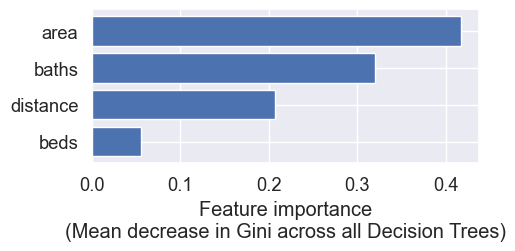

In [10]:
sns.set(font_scale=1.2)

# plot features through function
plot_feat_import(x_feat_list, rf_clf.feature_importances_, "classifier")

The plot shows that the area of the house is the most important feature when determining price, while the number of beds is the least important.

Although the graph indicates that area and housing prices are connected, we cannot conclude that an increase in area would increase the housing price through looking at the graph.

# Part 4: `RandomForestRegressor` and housing prices
In earlier parts of this HW, we used a `DecisionTree` and `RandomForestClassifier` to predict `price_bucket`.  Here we use a `RandomForestRegressor` to predict the housing `price` (not just the `price_bucket`).

See [this video](https://youtu.be/SiovCeiKuSY) (same as for lab5) for an "introduction" to `RandomForestRegressor`.

## Part 4.1: Compute a cross validated $R^2$ for a `RandomForestRegressor` (9 points)
    ... nobody cares which features are important in a regression model which can't predict accurately

In [11]:
import pandas as pd

df_house = pd.read_csv('boston_houses.csv', index_col=None)

df_house.head()

,beds,baths,area,distance,price,price_bucket
0,3.0,2.0,2584.0,18.726140,1100000.0,price >= 900k
1,1.0,1.0,650.0,1.053808,699000.0,600k <= price < 900k
2,2.0,3.0,1794.0,0.471038,1750000.0,price >= 900k
3,4.0,3.0,1831.0,3.611435,979000.0,price >= 900k
4,3.0,3.0,1875.0,2.200608,1875000.0,price >= 900k


In [12]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

n_splits = 10
max_depth = 3

# extract housing prices
y = df_boston.loc[:, 'price'].values
 
# initialize k fold
kfold = KFold(n_splits=n_splits, shuffle=True)

# initialize Random Forest Regressor
regr = RandomForestRegressor()

# initialize y_pred, stores predictions of y
y_pred = np.empty_like(y)

for train_idx, test_idx in kfold.split(x, y):
    # get training data
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    
    # get test data
    x_test = x[test_idx, :]
    
    # fit data
    regr = regr.fit(x_train, y_train)
    
    # estimate on test data
    y_pred[test_idx] = regr.predict(x_test)

      
# compute R2 score
r2 = r2_score(y_true=y, y_pred=y_pred)
r2

0.7508871751402195

## Part 4.2. Plot the feature importances of your `RandomForestRegressor` (8 points)

You should update `plot_feat_import()` to properly label the x axis.  (`RandomForestClassifier`s minimize Gini, what do `RandomForestRegressor`s minimize?)

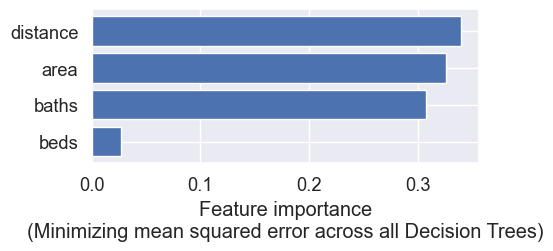

In [13]:
# plot features through function
plot_feat_import(x_feat_list, regr.feature_importances_, "regressor")

## Part 4.3 Regressor vs Classifier? (7 points) 
Between the `RandomForestRegressor`s and `RandomForestClassifier`, explain which feature importance graph you trust more.

### hints: 
- does the `RandomForestClassifier` distinguish between different house prices within a single bucket?
- wasn't our choice of 3 buckets somewhat arbitrary?  What if we used 10 price buckets instead, this can change the feature importances ... 

Because the RandomForestClassifier can only classify a house to a certain group rather than provide a prediciton of the actual price, I trust the RandomForestRegressor's feature importance graph more. The RandomForestClassifier is a more vague generalization where each house is classified based on a grouping we decided on, which makes it a less informative estimate as opposed to the RandomForestRegressor which is primarily making a prediction using mathematical calculations on the data available.

# Part 5: Ethics of Housing Pricing (16 points)

Using any housing model built and trained as above could (and likely would) do real harm to people if used without careful thought.  **Remember, these models only mimic and recreate the relationships between housing features and price in input data.  Given this, the predictions should be understood as a reflection of the flawed world from which they come and not some necessarily truthful, objective insight.** (I worry the mathematical complexity and "high-tech-factor" of many Machine Learning models gives them some credibility they haven't earned!)

In the case of predicting housing prices in Boston, we should be mindful of Redlining.  Naively used, this model can propogate and promote racist real estate processes via their influence in future housing prices.

Using the resources listed below, identify two distinct ways in which a biased model (one which overvalues the houses of white people while undervaluing the houses of people of color) might propogate [racism](http://msan.wceruw.org/conferences/2015-studentConf/Defining%20Racism%20by%20Beverly%20Daniel%20Tatum.pdf) if used to predict housing values (e.g. [Zillow](https://www.zillow.com/) or similar).  Please give each of the two impacts its own markdown heading (`###`) and write one to three sentences which characterize it.

- [Wikipedia on Redlining](https://en.wikipedia.org/wiki/Redlining)
    - good background
- [NPR Video (start here)](https://youtu.be/O5FBJyqfoLM?t=14) 
    - great summary
    - hint: they do mention 4 specific impacts of redlining ... any two would be sufficient here
    - be mindful of some spicy language and dark humor from Chris Rock which opens the video
- [NYTimes article](https://www.nytimes.com/2021/03/20/opinion/home-value-race-taxes.html) 
    - strong, specific stats
- [NyTimes article](https://www.nytimes.com/2022/08/18/realestate/housing-discrimination-maryland.html)
    - compelling single example
    
Note that the negative impact of the model does not require the model's builder have malicious intentions.  It is entirely possible that one can build and utilize models without considering the real world harm they could have when deployed.  (Its unsurprising even, when you consider how much thought we put into our more easily quantifiable objectives: $R^2$, accuracy, confusion matrix scores ... there's so much technical detail to get lost in we may not take our hands off the keyboard for long enough to appreciate the very real impact of the work we do!).  My own belief is that much of the harm ML models have done, in practice, is not the result of bad people intentionally building harmful models but everyday people, like you and I, not being thoughtful enough in how the ML models will be used in the real world.

### Educational quality gap
Because schools are funded primarily throguh property taxes, communities with better-valued houses have better school systems with more resources. The better the school system, the higher the property value, creating a cycle of educational quality with high valued properties. Therefore, a biased model would propegate this cycle which would ultimately result in white overvalued houses with better education systems and black undervalued houses with a lack of resources. 

### Harmful living conditions

Those that live in richer, more priviledged neighborhood not only have better access to community resources, but also live in areas with better sanitation. Low-income communities with lower property values are more likely to be exposed to toxic chemicals, undrinkable water, unstable infastructure, and farther away from grocery stores with fresh food, leading to a higher chance of disease for the neighborhood population. A biased model would exacerbate this issue by creating more white, priviledged communities with better sanitation and resources and more black, low-income communities with a lack of proper housing and sanitiation.